<a href="https://colab.research.google.com/github/Aurelien07/Kaggle_competition/blob/main/Poker_rule_induction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small explaination about the project :

You are provided with 25,010 poker hands in train.csv and 1,000,000 in test.
csv. 

Each hand consists of five cards with a given suit and rank, drawn from a standard deck of 52. Suits and ranks are represented as ordinal categories:

S1 “Suit of card #1”

Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

C1 “Rank of card #1”

Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)


S5 “Suit of card #5”
C5 “Rank of card #5”

- 0: Nothing in hand; not a recognized poker hand 

- 1: One pair; one pair of equal ranks within five cards

- 2: Two pairs; two pairs of equal ranks within five cards

- 3: Three of a kind; three equal ranks within five cards

- 4: Straight; five cards, sequentially ranked with no gaps

- 5: Flush; five cards with the same suit

- 6: Full house; pair + different rank three of a kind

- 7: Four of a kind; four equal ranks within five cards

- 8: Straight flush; straight + flush

- 9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

## Function :

In [1]:
def preprocess_data(df):
    # Gestion des valeurs manquantes
    imputer = SimpleImputer(strategy='mean')
    df_filled = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Encodage des caractéristiques catégorielles
    categorical_features = df_filled.select_dtypes(include=['object']).columns
    label_encoder = LabelEncoder()
    for feature in categorical_features:
        df_filled[feature] = label_encoder.fit_transform(df_filled[feature])

    # Normalisation des caractéristiques numériques
    numeric_features = df_filled.select_dtypes(include=['float', 'int']).columns
    scaler = StandardScaler()
    df_filled[numeric_features] = scaler.fit_transform(df_filled[numeric_features])

    return df_filled

## Import library

In [2]:
# for basic stuff in python
import pandas as pd
import numpy as np

# for vizualisation : 
import matplotlib.pyplot as plt
import seaborn as sns

# against warnings :
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# for prediction :
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/poker-rule-induction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/poker-rule-induction/sampleSubmission.csv.zip
/content/drive/My Drive/Colab Notebooks/poker-rule-induction/test.csv.zip
/content/drive/My Drive/Colab Notebooks/poker-rule-induction/train.csv.zip
/content/drive/My Drive/Colab Notebooks/poker-rule-induction/Poker_rule_induction.ipynb
/content/drive/My Drive/Colab Notebooks/poker-rule-induction/xgb_model_best.h5
/content/drive/My Drive/Colab Notebooks/poker-rule-induction/grid_search_accuracy.png
/content/drive/My Drive/Colab Notebooks/poker-rule-induction/best_params.pkl
/content/drive/My Drive/Colab Notebooks/poker-rule-induction/best_score.pkl
/content/drive/My Drive/Colab Notebooks/poker-rule-induction/xgb_model.log


In [5]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/poker-rule-induction/train.csv.zip")

### Vizualisation :

In [6]:
print("Vizualisation for the DataFrame :")
display(df)
print("")
print("Vizualisation for the DataFrame Describe :")
display(df.describe(include='all'))

Vizualisation for the DataFrame :


,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,4,9,2,1,2,2,4,7,2,8,0
1,1,4,3,6,1,12,3,11,2,7,0
2,1,11,4,1,3,7,4,11,2,1,2
3,2,9,2,4,3,6,1,9,4,9,3
4,1,8,2,4,2,11,2,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...
25005,4,9,4,6,3,6,4,12,4,5,1
25006,3,8,3,5,4,11,2,2,1,13,0
25007,1,8,4,5,3,11,3,2,2,13,0
25008,4,12,3,5,2,1,2,7,4,6,0



Vizualisation for the DataFrame Describe :


,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
count,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000
mean,2.508756,6.995242,2.497721,7.014194,2.510236,7.014154,2.495922,6.942463,2.497321,6.962735,0.621152
std,1.116483,3.749805,1.121767,3.766974,1.123148,3.744974,1.116009,3.747147,1.118732,3.741579,0.788361
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000,0.000000
50%,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,1.000000
75%,4.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,3.000000,10.000000,1.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,9.000000


# Exploration of data :

## Distribution of Class :

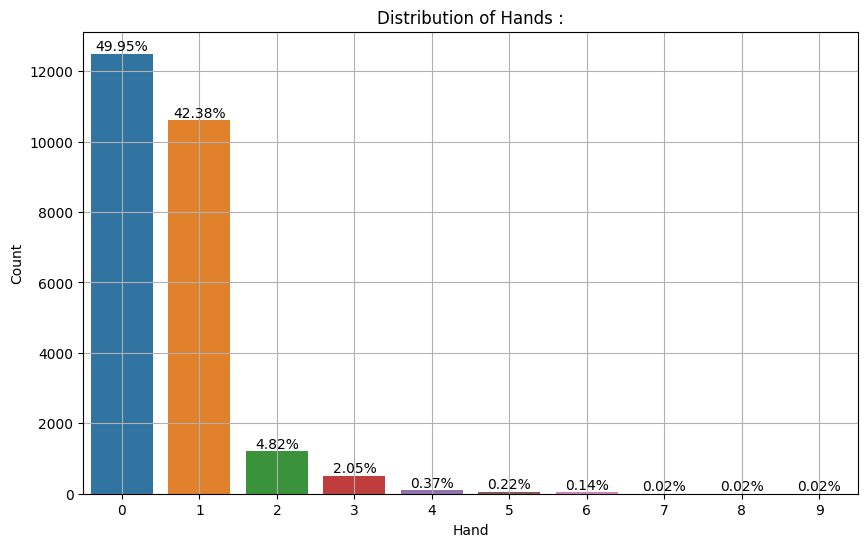

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# For the figure -> seaborn

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='hand')

# Apply Percentage for the bar :

total_count = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total_count*100:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# for title and grid :

plt.xlabel('Hand')
plt.ylabel("Count")
plt.title('Distribution of Hands :')
plt.grid(True)
plt.show()

In [8]:
## Univarié :

Choisissez une classe (0-9) : 0
Choisissez une caractéristique (S1, C1, S2, C2, S3, C3, S4, C4, S5, C5) : C2


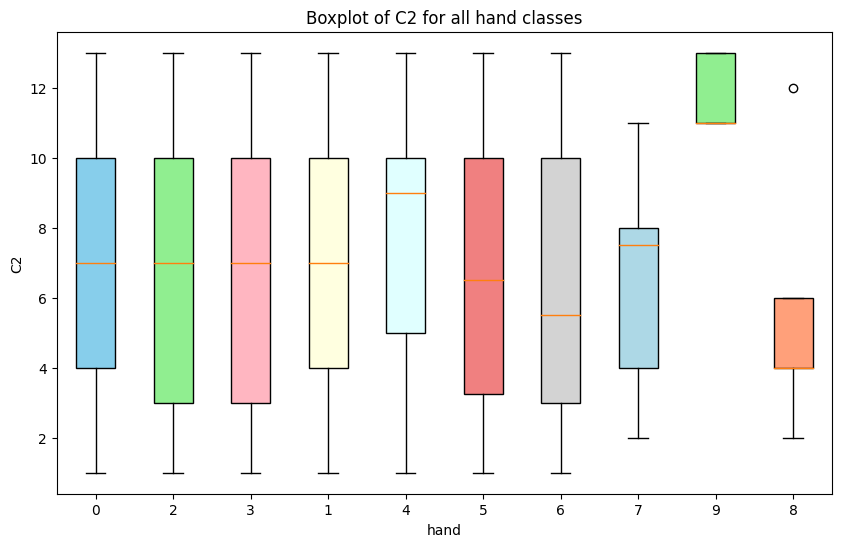

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Demande à l'utilisateur de choisir la classe et la caractéristique
chosen_class = int(input("Choisissez une classe (0-9) : "))
chosen_feature = input("Choisissez une caractéristique (S1, C1, S2, C2, S3, C3, S4, C4, S5, C5) : ")

# Vérification de l'entrée utilisateur

if chosen_class not in df['hand'].unique() or chosen_feature not in df.columns:
    print("Classe ou caractéristique invalide !")
else:

    # Couleurs personnalisées pour les boxplots :
    colors = ['skyblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightcyan', 'lightcoral', 'lightgrey', 'lightblue', 'lightgreen', 'lightsalmon']

    # Diagramme en boîte pour la caractéristique choisie en fonction de toutes les classes :
    plt.figure(figsize=(10, 6))
    boxplot_data = [df[df['hand'] == hand_class][chosen_feature] for hand_class in df['hand'].unique()]
    boxplot = plt.boxplot(boxplot_data, labels=[str(hand_class) for hand_class in df['hand'].unique()], patch_artist=True)

    # Personnalisation des couleurs des boxplots
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel('hand')
    plt.ylabel(chosen_feature)
    plt.title(f"Boxplot of {chosen_feature} for all hand classes")
    plt.show()

## multivarié :

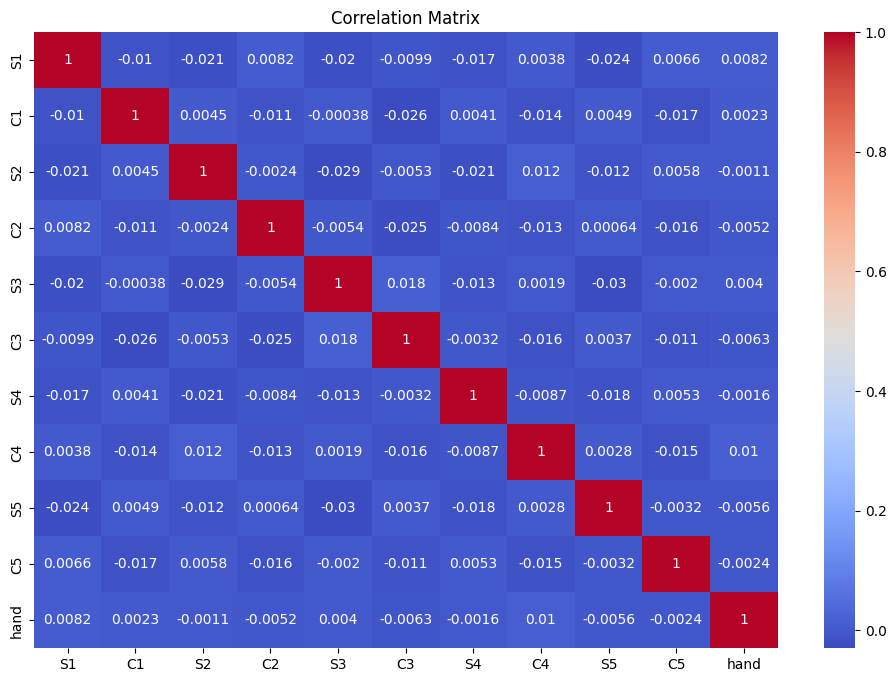

In [10]:
# Calcul de la matrice de corrélation
corr_matrix = df.corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Encoding data :

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [12]:
# Diviser les caractéristiques et la classe
X = df.drop('hand', axis=1)  # Caractéristiques
y = df['hand']  # Classe

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""# Standardisation des données d'entraînement
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Application de la transformation de standardisation sur les données de test
X_test_scaled = scaler.transform(X_test)"""

"# Standardisation des données d'entraînement\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\n\n# Application de la transformation de standardisation sur les données de test\nX_test_scaled = scaler.transform(X_test)"

In [13]:
# X_test_scaled

# Algorithm :

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

## Xgboost :

In [15]:
"""import pickle
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Define the scoring metric (accuracy in this case)
scorer = make_scorer(accuracy_score)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model XGBoost
xgb_model = XGBClassifier()

# Gridsearch with crossvalidation and scoring history
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Define the callbacks
class ModelCheckpointCallback(xgb.callback.TrainingCallback):
    def __init__(self, save_path):
        self.save_path = save_path
    
    def after_iteration(self, model, epoch, evals_log):
        if (epoch + 1) % 10 == 0:
            model.save_model(self.save_path)

checkpointer = ModelCheckpointCallback('/content/drive/My Drive/Colab Notebooks/poker-rule-induction/xgb_model_best.h5')
early_stopping = xgb.callback.EarlyStopping(5)

# Define a custom callback to log metrics to a CSV file
class CSVLoggerCallback(xgb.callback.TrainingCallback):
    def __init__(self, filename):
        self.filename = filename
        self.file = open(filename, 'w')
        self.file.write('iteration,train_score,test_score\n')
    
    def after_iteration(self, model, epoch, evals_log):
        iteration = epoch + 1
        train_score = evals_log['validation_0']['mlogloss']
        if 'validation_1' in evals_log:
            test_score = evals_log['validation_1']['mlogloss']
        else:
            test_score = None
        self.file.write(f'{iteration},{train_score},{test_score}\n')
    
    def close(self):
        self.file.close()

csv_logger = CSVLoggerCallback('/content/drive/My Drive/Colab Notebooks/poker-rule-induction/xgb_model.log')
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=5,
    scoring=scorer,
    return_train_score=True
)
xgb_grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[checkpointer, early_stopping, csv_logger])

# Retrieve the scoring history
train_scores = xgb_grid_search.cv_results_['mean_train_score']
test_scores = xgb_grid_search.cv_results_['mean_test_score']

# Plot the scores over the iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_scores)), train_scores, label='Train Score')
plt.plot(range(len(test_scores)), test_scores, label='Test Score')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Grid Search Accuracy')
plt.legend()
plt.savefig('grid_search_accuracy.png')  # Save the figure

# Print results
best_params = xgb_grid_search.best_params_
best_score = xgb_grid_search.best_score_

# Save best_params and best_score using pickle
with open('/content/drive/My Drive/Colab Notebooks/poker-rule-induction/best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)
with open('/content/drive/My Drive/Colab Notebooks/poker-rule-induction/best_score.pkl', 'wb') as f:
    pickle.dump(best_score, f)"""

"import pickle\nfrom sklearn.metrics import make_scorer\nfrom sklearn.model_selection import GridSearchCV\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\nimport xgboost as xgb\n\n# Define the scoring metric (accuracy in this case)\nscorer = make_scorer(accuracy_score)\n\n# Split the data into train and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Model XGBoost\nxgb_model = XGBClassifier()\n\n# Gridsearch with crossvalidation and scoring history\nxgb_param_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [3, 5, 7],\n    'learning_rate': [0.1, 0.01, 0.001]\n}\n\n# Define the callbacks\nclass ModelCheckpointCallback(xgb.callback.TrainingCallback):\n    def __init__(self, save_path):\n        self.save_path = save_path\n    \n    def after_iteration(self, model, epoch, evals_log):\n        if (epoch + 1) % 10 == 0:\n         

In [ ]:
import pickle
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define the scoring metric (accuracy in this case)
scorer = make_scorer(accuracy_score)

# Model XGBoost
xgb_model = XGBClassifier()

# Gridsearch with cross-validation and scoring history
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=5,
    scoring=scorer,
    return_train_score=True
)

xgb_grid_search.fit(X_train, y_train)

# Retrieve the scoring history
train_scores = xgb_grid_search.cv_results_['mean_train_score']
test_scores = xgb_grid_search.cv_results_['mean_test_score']

# Plot the scores over the iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_scores)), train_scores, label='Train Score')
plt.plot(range(len(test_scores)), test_scores, label='Test Score')
plt.xlabel('Numbers of Iterations')
plt.ylabel('Accuracy')
plt.title('XGBoost Classifier')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/My Drive/Colab Notebooks/poker-rule-induction/grid_search_accuracy.png')  # Save the figure

# Print results
best_params = xgb_grid_search.best_params_
best_score = xgb_grid_search.best_score_

# Save best_params and best_score using pickle
with open('/content/drive/My Drive/Colab Notebooks/poker-rule-induction/best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)
with open('/content/drive/My Drive/Colab Notebooks/poker-rule-induction/best_score.pkl', 'wb') as f:
    pickle.dump(best_score, f)


## Adaboost :

In [17]:
%%time
# Model AdaBoost :
adaboost_model = AdaBoostClassifier()

# Gridsearch :
adaboost_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Gridsearch with crossvalidation :
adaboost_grid_search = GridSearchCV(adaboost_model, adaboost_param_grid, cv=5)
adaboost_grid_search.fit(X_train, y_train)

# print results :
print("Meilleurs hyperparamètres pour AdaBoost : ", adaboost_grid_search.best_params_)
print("Score correspondant : ", adaboost_grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: ignored

## Random Forest :

## K.N.N :